## DASC 550 Project3: Electricity Demand Prediction
### [[Hamza]] [[Dehidi]]
### 0077989

#### Submission Deadline: August 29, 2022 11:59 PM

In this project, you are going to build an end-to-end machine learning solution using a recurrent neural network for electricity demand prediction problem. You should use `tensorflow` library to build your neural network.

The data set is provided at  https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption, which contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). The measurements are given at the minute resolution. You should first resample data to obtain hourly measurements using `pandas.DataFrame.resample` function. The target variable is at `global_active_power` column. You will predict the electricity demand of the next hour using past measurements.

While building your regression model, you should decide what to do with missing values and how to split the data set into learning, validation and test sets. You should report the predictive performances on learning, validation and test sets.

You should also report the metrics you choose to measure the performance of the solution you developed and the reasoning behind your choices.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt

In [2]:
# Downloading the data
!gdown https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

Downloading...
From: https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
To: /content/household_power_consumption.zip
100% 20.6M/20.6M [00:00<00:00, 23.2MB/s]


In [3]:
# Unzipping the data
!unzip -qq household_power_consumption.zip

In [4]:
# load all data
data = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

# summarize
print(data.shape)

(2075259, 7)


In [5]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
print(data.isna().sum())

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


In [7]:
# The other columns' missing data is shown as "?"
data[data["Sub_metering_3"].isna()].head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-21 11:23:00,?,?,?,?,?,?,NaN
2006-12-21 11:24:00,?,?,?,?,?,?,NaN
2006-12-30 10:08:00,?,?,?,?,?,?,NaN
2006-12-30 10:09:00,?,?,?,?,?,?,NaN
2007-01-14 18:36:00,?,?,?,?,?,?,NaN


In [8]:
# mark all missing values
data.replace('?', np.nan, inplace=True)

In [9]:
data[data["Sub_metering_3"].isna()].head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Dividing the data to 50% training, 25% validation and 25% test.
num_train_samples = int(0.5 * len(data))
num_val_samples = int(0.25 * len(data))
num_test_samples = len(data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1037629
num_val_samples: 518814
num_test_samples: 518816


In [11]:
# forward filling the missing data.

X_train = data.iloc[:num_train_samples].fillna(method = "ffill")
y_train = data["Global_active_power"].iloc[:num_train_samples].fillna(method = "ffill")

X_val = data.iloc[num_train_samples:(num_train_samples+num_val_samples)].fillna(method = "ffill")
y_val = data["Global_active_power"].iloc[num_train_samples:(num_train_samples+num_val_samples)].fillna(method = "ffill")

X_test = data[(num_train_samples+num_val_samples):].fillna(method = "ffill")
y_test = data["Global_active_power"].iloc[(num_train_samples+num_val_samples):].fillna(method = "ffill")

In [12]:
# Changing the data type to float

X_train = X_train.astype(float)
y_train = y_train.astype(float)

X_val = X_val.astype(float)
y_val = y_val.astype(float)

X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [13]:
# Resampling to hours

X_train = X_train.resample('H').sum()
y_train = y_train.resample('H').sum()

X_val = X_val.resample('H').sum()
y_val = y_val.resample('H').sum()

X_test = X_test.resample('H').sum()
y_test = y_test.resample('H').sum()

In [14]:
X_train.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0


In [15]:
# Extracting the days and months.

days_train = X_train.index.day.to_numpy()
days_train = days_train[:,None] / 31
months_train = X_train.index.month.to_numpy()
months_train = months_train[:,None] / 12

days_val = X_val.index.day.to_numpy()
days_val = days_val[:,None] / 31
months_val = X_val.index.month.to_numpy()
months_val = months_val[:,None] / 12

days_test = X_test.index.day.to_numpy()
days_test = days_test[:,None] / 31
months_test = X_test.index.month.to_numpy()
months_test = months_test[:,None] / 12

print(len(days_train))
print(len(days_val))
print(len(days_test))

17295
8648
8648


In [16]:
# Converting Dataframe and Series to numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()[:, None]

X_val = X_val.to_numpy()
y_val = y_val.to_numpy()[:, None]

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()[:, None]


print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(17295, 7) (8648, 7) (8648, 7)
(17295, 1) (8648, 1) (8648, 1)


In [17]:
# Due to the various scales of the features
# it is possible that features with greater magnitude will be given more weight.
# so by scaling all the features, we ensure that all are equally important.

from sklearn.preprocessing import MinMaxScaler

scaler_y = MinMaxScaler(feature_range = (0.05, 0.95))
y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

scaler_X = MinMaxScaler(feature_range = (0.05, 0.95))
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

print(np.min(y_train), np.max(y_train))
print(np.min(y_val), np.max(y_val))
print(np.min(y_test), np.max(y_test))

0.05 0.9499999999999998
0.0405989766748146 0.9442810829846293
0.039196047561834535 0.8194436963997181


In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator
"""
TimeseriesGenerator gives us windows extracted from the original timeseries example as below this is 
computed on fly which is very memory efficient.

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7

"""
window_size = 24
generator_train = TimeseriesGenerator(X_train,
                                      y_train,
                                      length = window_size,
                                      batch_size = 32)

generator_val = TimeseriesGenerator(X_val,
                                    y_val,
                                    length = window_size)

generator_test = TimeseriesGenerator(X_test,
                                     y_test,
                                     length = window_size)

In [19]:
# Defining the early stop
early_stop = [keras.callbacks.EarlyStopping(monitor = "val_loss",
                                            patience = 5,
                                            restore_best_weights = True)]
                                            

## **LSTM Models**

In [20]:
LSTM20_model = keras.models.Sequential([
    keras.layers.LSTM(units = 20, input_shape = (window_size, X_train.shape[1])),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 1)
])

LSTM20_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2240      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


In [21]:
LSTM20_model.compile(optimizer = "adam",
                    loss = "mean_squared_error")

In [22]:
LSTM20_history = LSTM20_model.fit(generator_train,
                                  steps_per_epoch = len(generator_train),
                                  epochs = 40,
                                  validation_data=generator_val,
                                  callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 9s 6ms/step - loss: 0.0172 - val_loss: 0.0084
Epoch 2/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 3/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 4/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 5/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 6/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 7/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 8/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 9/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 10/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0077 - val_loss: 0.0063

In [23]:
from sklearn.metrics import mean_squared_error

y_test_hat_LSTM20 = LSTM20_model.predict(generator_test)
y_test_hat_LSTM20_scaled = scaler_y.inverse_transform(y_test_hat_LSTM20)[:,0]

y_test_original = scaler_y.inverse_transform(y_test)[:,0]
print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_LSTM20_scaled)))

Test RMSE:  31.065927808227244


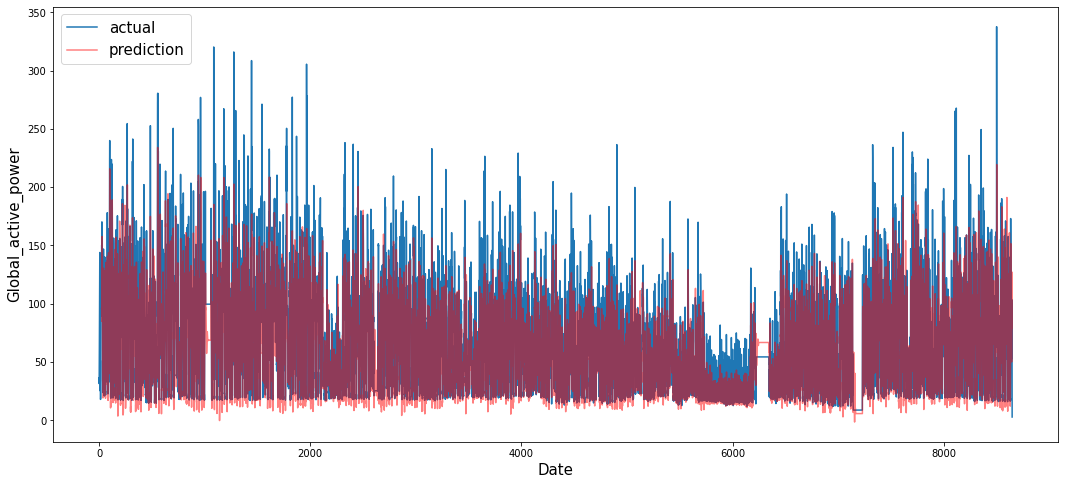

In [24]:
test_index = np.arange(len(y_test))

plt.figure(figsize = (18, 8))
plt.plot(test_index, y_test_original, label="actual")
plt.plot(test_index[window_size:], y_test_hat_LSTM20_scaled, 'r',alpha=0.5, label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [25]:
# plotting one month predictions
def plot30(y_test_hat_scaled):
  plt.figure(figsize = (18, 8))
  plt.plot(test_index[2000:2720], y_test_original[2000:2720], label="actual")
  plt.plot(test_index[2000:2720], y_test_hat_scaled[1976:2696], 'r',alpha=0.5, label="prediction")
  plt.ylabel('Global_active_power', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=15)
  plt.show()

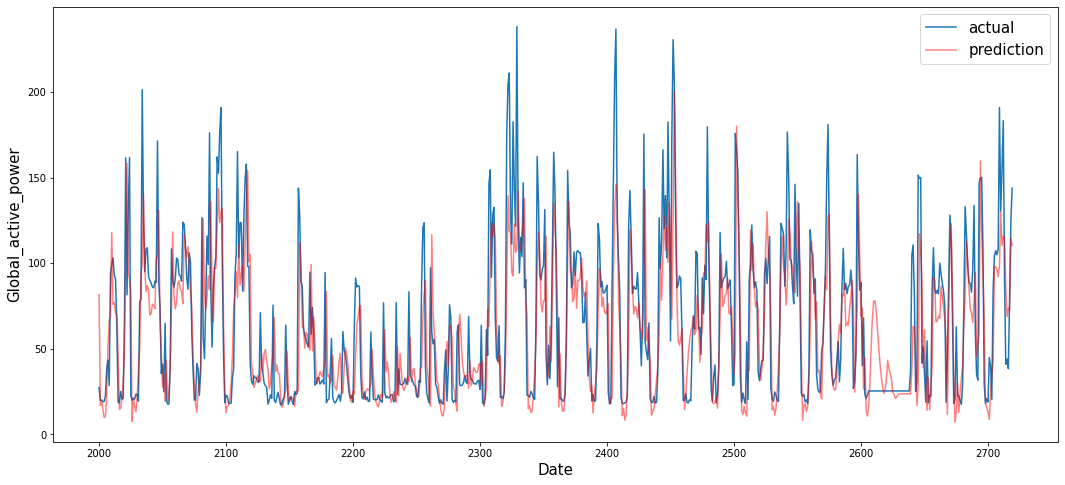

In [26]:
plot30(y_test_hat_LSTM20_scaled)

# 2nd LSTM

In [27]:
LSTM100_model = keras.models.Sequential([
    keras.layers.LSTM(units = 100, input_shape = (window_size, X_train.shape[1])),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 1)
])

LSTM100_model.summary()

LSTM100_model.compile(optimizer = "adam",
                    loss = "mean_squared_error")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               43200     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [28]:
LSTM100_history = LSTM100_model.fit(generator_train,
                                    steps_per_epoch = len(generator_train),
                                    epochs = 40,
                                    validation_data=generator_val,
                                    callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 4s 6ms/step - loss: 0.0113 - val_loss: 0.0070
Epoch 2/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 3/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 4/40
540/540 [==============================] - 3s 6ms/step - loss: 0.0076 - val_loss: 0.0058
Epoch 5/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 6/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 7/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 8/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 9/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 10/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0069 - val_loss: 0.0057

In [29]:
y_test_hat_LSTM100 = LSTM100_model.predict(generator_test)
y_test_hat_LSTM100_scaled = scaler_y.inverse_transform(y_test_hat_LSTM100)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_LSTM100_scaled)))

Test RMSE:  30.660586896171054


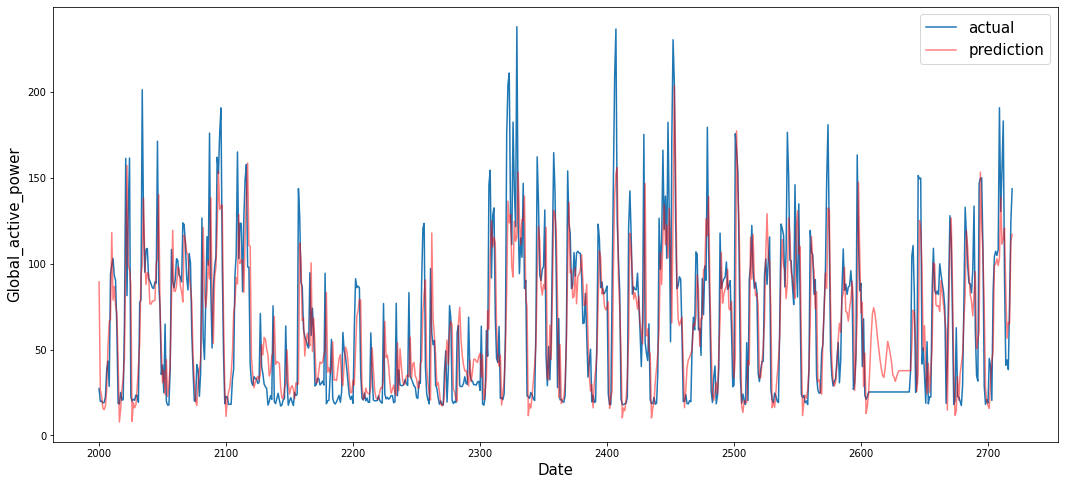

In [30]:
plot30(y_test_hat_LSTM100_scaled)

# 3rd LSTM

In [31]:
LSTM256_model = keras.models.Sequential([
    keras.layers.LSTM(units = 256, input_shape = (window_size, X_train.shape[1])),
    keras.layers.Dense(units = 128, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dense(units = 1)
])

LSTM256_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               270336    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 305,313
Trainable params: 305,313
Non-trainable params: 0
_________________________________________________________________


In [32]:
LSTM256_model.compile(optimizer = "adam",
                  loss = "mean_squared_error")

In [33]:
LSTM256_history = LSTM256_model.fit(generator_train,
                                    steps_per_epoch = len(generator_train),
                                    epochs = 40,
                                    validation_data=generator_val,
                                    callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 5s 6ms/step - loss: 0.0113 - val_loss: 0.0069
Epoch 2/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 3/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0074 - val_loss: 0.0056
Epoch 4/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 5/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 6/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 7/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 8/40
540/540 [==============================] - 3s 6ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 9/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 10/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0067 - val_loss: 0.0054

In [34]:
y_test_hat_LSTM256 = LSTM256_model.predict(generator_test)
y_test_hat_LSTM256_scaled = scaler_y.inverse_transform(y_test_hat_LSTM256)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_LSTM256_scaled)))

Test RMSE:  30.21197411206364


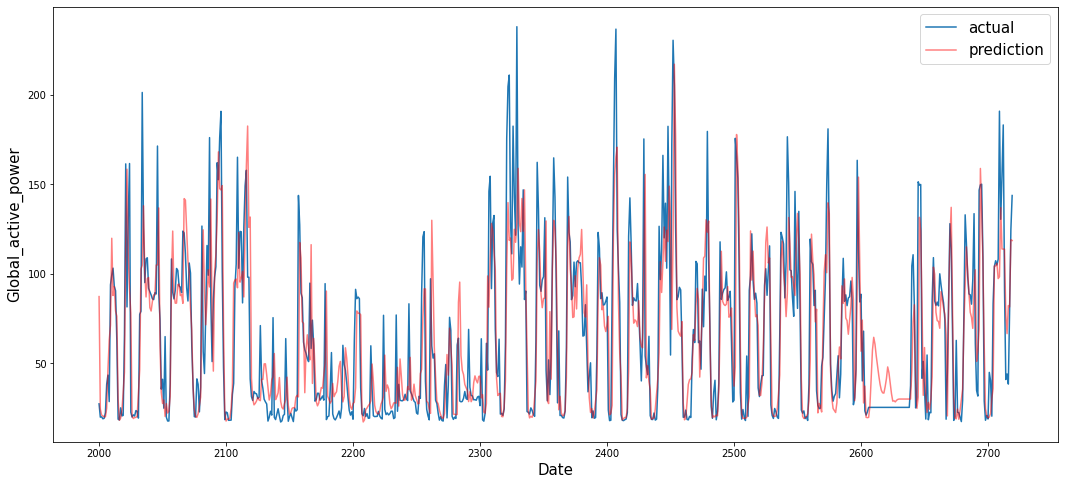

In [35]:
plot30(y_test_hat_LSTM256_scaled)

## GRU model

In [36]:
gru20_model = keras.models.Sequential([
                keras.layers.GRU(units = 20, input_shape = (window_size, X_train.shape[1])),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(units = 1)
])

gru20_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20)                1740      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [37]:
gru20_model.compile(optimizer = "adam",
                    loss = "mean_squared_error")

In [38]:
gru20_history = gru20_model.fit(generator_train,
                                steps_per_epoch = len(generator_train),
                                epochs = 40,
                                validation_data=generator_val,
                                callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 4s 5ms/step - loss: 0.0148 - val_loss: 0.0076
Epoch 2/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 3/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 4/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 5/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 6/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 7/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0079 - val_loss: 0.0061
Epoch 8/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0078 - val_loss: 0.0061
Epoch 9/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 10/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0076 - val_loss: 0.0059

In [39]:
y_test_hat_gru20 = gru20_model.predict(generator_test)
y_test_hat_gru20_scaled = scaler_y.inverse_transform(y_test_hat_gru20)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_gru20_scaled)))

Test RMSE:  31.223888085924507


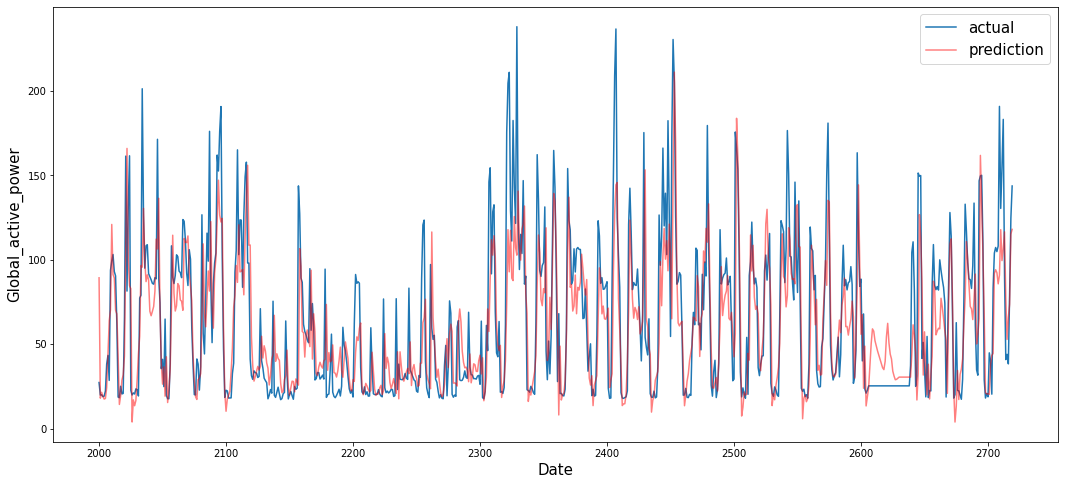

In [40]:
plot30(y_test_hat_gru20_scaled)

# 2nd GRU

In [41]:
gru100_model = keras.models.Sequential([
    keras.layers.GRU(units = 100, input_shape = (window_size, X_train.shape[1])),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 1)
])

gru100_model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 100)               32700     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 32,801
Trainable params: 32,801
Non-trainable params: 0
_________________________________________________________________


In [42]:
gru100_model.compile(optimizer = "adam",
                     loss = "mean_squared_error")

In [43]:
gru100_history = gru100_model.fit(generator_train,
                              steps_per_epoch = len(generator_train),
                              epochs = 40,
                              validation_data=generator_val,
                              callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 4s 5ms/step - loss: 0.0120 - val_loss: 0.0067
Epoch 2/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 3/40
540/540 [==============================] - 2s 4ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 4/40
540/540 [==============================] - 2s 5ms/step - loss: 0.0078 - val_loss: 0.0064
Epoch 5/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 6/40
540/540 [==============================] - 3s 6ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 7/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 8/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 9/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 10/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0056

In [44]:
y_test_hat_gru100 = gru100_model.predict(generator_test)
y_test_hat_gru100_scaled = scaler_y.inverse_transform(y_test_hat_gru100)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_gru100_scaled)))

Test RMSE:  30.59419401587058


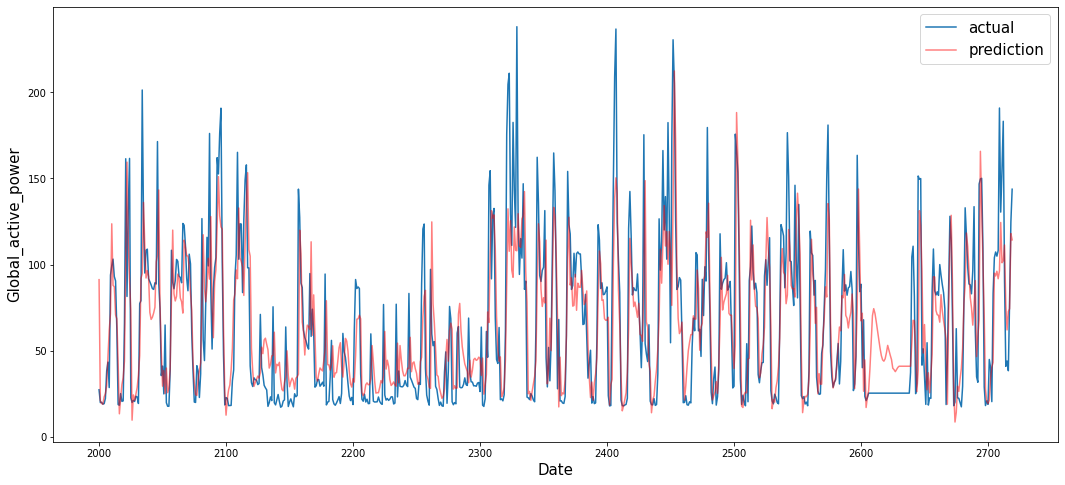

In [45]:
plot30(y_test_hat_gru100_scaled)

# 3nd GRU model

In [46]:
gru256_model = keras.models.Sequential([
    keras.layers.GRU(units = 256, input_shape = (window_size, X_train.shape[1])),
    keras.layers.Dense(units = 128, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dense(units = 1)
])

gru256_model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 256)               203520    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 238,497
Trainable params: 238,497
Non-trainable params: 0
_________________________________________________________________


In [47]:
gru256_model.compile(optimizer = "adam", loss = "mean_squared_error")

In [48]:
gru256_history = gru256_model.fit(generator_train,
                                  steps_per_epoch = len(generator_train),
                                  epochs = 40,
                                  validation_data=generator_val,
                                  callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 5s 6ms/step - loss: 0.0103 - val_loss: 0.0068
Epoch 2/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 3/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 4/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 5/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 6/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 7/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 8/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 9/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 10/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0065 - val_loss: 0.0054

In [49]:
y_test_hat_gru256 = gru256_model.predict(generator_test)
y_test_hat_gru256_scaled = scaler_y.inverse_transform(y_test_hat_gru256)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_gru256_scaled)))

Test RMSE:  29.926462822438115


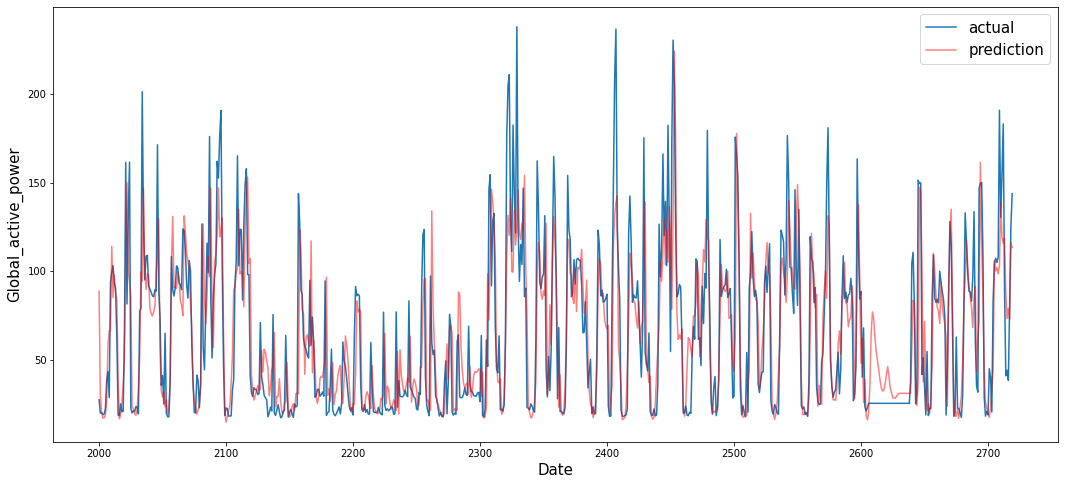

In [50]:
plot30(y_test_hat_gru256_scaled)

### **After observing that adding more units or layers had no discernible effect on lowering the test error, we will now attempt to extract new features in the hope of further enhancing the model.**


In [51]:
X_train = np.hstack((X_train, days_train, months_train))

X_val = np.hstack((X_val, days_val, months_val))

X_test = np.hstack((X_test, days_test, months_test))

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(17295, 9)
(8648, 9)
(8648, 9)


In [52]:
generator_train = TimeseriesGenerator(X_train,
                                      y_train,
                                      length = window_size,
                                      batch_size = 32)

generator_val = TimeseriesGenerator(X_val,
                                    y_val,
                                    length = window_size)

generator_test = TimeseriesGenerator(X_test,
                                     y_test,
                                     length = window_size)

In [57]:
gru256_model.compile(optimizer = "adam", loss = "mean_squared_error")

In [58]:
gru256_history = gru256_model.fit(generator_train,
                                  steps_per_epoch = len(generator_train),
                                  epochs = 40,
                                  validation_data=generator_val,
                                  callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 5s 6ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 2/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 3/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0073 - val_loss: 0.0116
Epoch 4/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 5/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 6/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 7/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0068 - val_loss: 0.0089
Epoch 8/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 9/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 10/40
540/540 [==============================] - 3s 5ms/step - loss: 0.0072 - val_loss: 0.0075

In [66]:
y_test_hat_gru256 = gru256_model.predict(generator_test)
y_test_hat_gru256_scaled = scaler_y.inverse_transform(y_test_hat_gru256)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_gru256_scaled)))

Test RMSE:  35.68332018320954


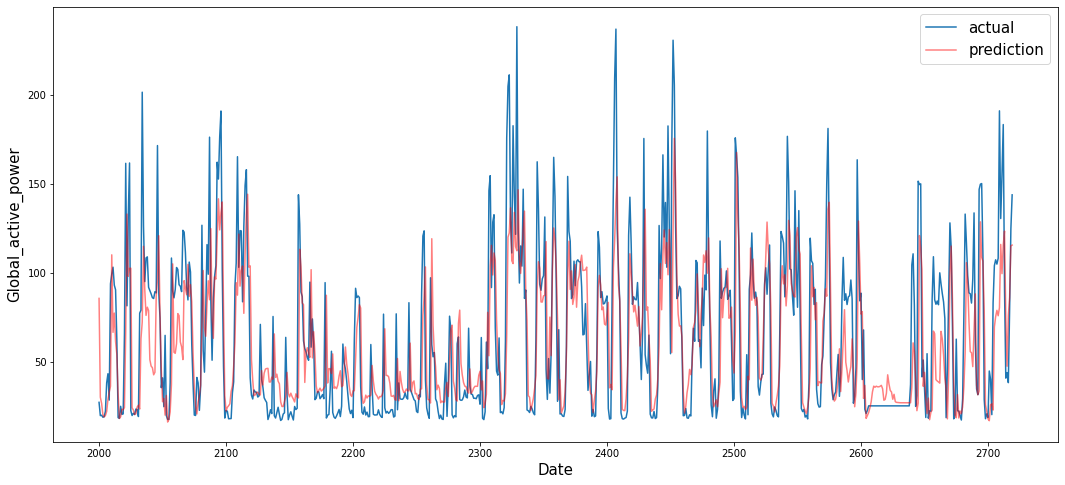

In [62]:
plot30(y_test_hat_gru256_scaled)

**We observed that the derived features enhanced the model even more, and we reduced test error.**

In [75]:
test_model = keras.models.Sequential([
    keras.layers.GRU(256, recurrent_dropout=0.5, return_sequences=True, unroll=True, input_shape = (window_size, X_train.shape[1])),
    keras.layers.GRU(256, recurrent_dropout=0.5, unroll=True),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 1)
])

test_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 24, 256)           205056    
                                                                 
 gru_8 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 257       
                                                                 
Total params: 600,065
Trainable params: 600,065
Non-trainable params: 0
_________________________________________________________________


In [76]:
test_model.compile(optimizer = "adam", loss = "mean_squared_error")

In [77]:
test_history = test_model.fit(generator_train,
                                  steps_per_epoch = len(generator_train),
                                  epochs = 40,
                                  validation_data=generator_val,
                                  callbacks= early_stop)

Epoch 1/40
540/540 [==============================] - 70s 51ms/step - loss: 0.0117 - val_loss: 0.0067
Epoch 2/40
540/540 [==============================] - 24s 45ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 3/40
540/540 [==============================] - 24s 45ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 4/40
540/540 [==============================] - 24s 45ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 5/40
540/540 [==============================] - 25s 46ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 6/40
540/540 [==============================] - 24s 44ms/step - loss: 0.0076 - val_loss: 0.0059
Epoch 7/40
540/540 [==============================] - 25s 46ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 8/40
540/540 [==============================] - 25s 46ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 9/40
540/540 [==============================] - 25s 47ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 10/40
540/540 [==============================] - 26s 48ms/step - loss: 0.007

In [78]:
y_test_hat_test = test_model.predict(generator_test)
y_test_hat_test_scaled = scaler_y.inverse_transform(y_test_hat_test)[:,0]

print("Test RMSE: ", np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_test_scaled)))

Test RMSE:  30.895646246184487
